**Name:** YANG Yongze

**EID:** 60926970

# CS5489 - Tutorial 6
## Dimensionality Reduction and Face Recognition

In this tutorial you will use linear and non-linear dimensionality reduction on face images, and then train a classifier for face recognition. In the second part, you will then use dimensionality reduction for de-noising.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
random.seed(100)
rbow = plt.get_cmap('rainbow')

## Loading Data and Pre-processing
We first need to load the images.  Download `olivetti_py3.pkz` from Canvas, and place it in in the same directory as this ipynb file.  _DO NOT UNZIP IT_.  Then run the following cell to load the images.

In [2]:
oli = datasets.fetch_olivetti_faces(data_home="./")
X = oli.data.astype('float')
Y = oli.target
img = oli.images
imgsize = oli.images[0].shape

Each image is a 64x64 array of pixel values, resulting in a 4096 dimensional vector.  Run the below code to show an example:

(64, 64)


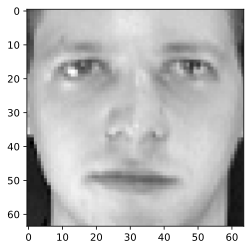

In [3]:
print(img[0].shape)
plt.imshow(img[0], cmap='gray', interpolation='nearest')
plt.show()

Run the below code to show all the images!

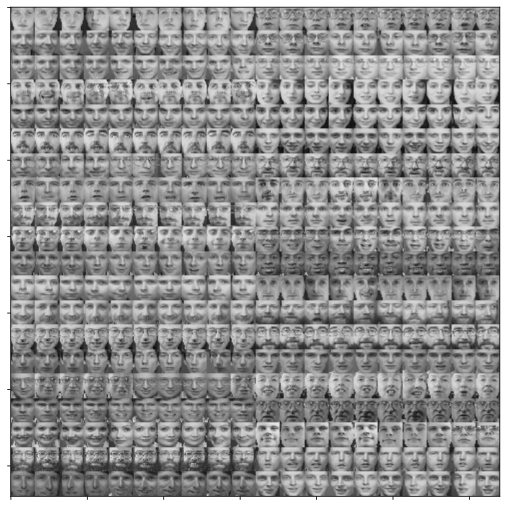

In [4]:
tmp = []
for i in range(0,400,20):
    tmp.append( hstack(img[i:i+20]) )
allimg = vstack(tmp)
plt.figure(figsize=(9,9))
plt.imshow(allimg, cmap='gray', interpolation='nearest')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.show()

Each person is considered as one class, and there are 10 images for each class.  In total there are 40 classes (people).  The data is already vectorized and put into the matrix `X`. The class labels are in vector `Y`. Now we split the data into training and testing sets.

In [5]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainX.shape)
print(testX.shape)

(320, 4096)
(80, 4096)


# Linear Dimensionality Reduction - PCA
The dimension of the data is too large (4096) so learning classifiers will take a long time.  Instead, our strategy is to use PCA to reduce the dimension first and then use the PCA weights as the representation for each image.  Run PCA oon the data using 9 principal components.

In [98]:
pca = decomposition.PCA(n_components=9)
W_train = pca.fit_transform(trainX)
W_test = pca.transform(testX)  # returns the coefficients

print(W_train.shape)
print(W_test.shape)


(320, 9)
(80, 9)


The below function will plot the basis vectors of PCA. Run the next 2 cells to view the PCs.

In [99]:
def plot_basis(model, imgsize):
    cname = model.__class__.__name__
    if  cname == 'LDA':
        KK = model.n_components
        comps = model.coef_
        mn    = None
    elif cname == 'PCA':
        KK = model.n_components_
        comps = model.components_
        mn    = model.mean_
    elif cname == 'NMF':
        KK = model.n_components_
        comps = model.components_
        mn    = None
    K = KK
    if mn is not None:
        K += 1        
    nr = int(ceil(K/5.0))
    sind = 1

    #vmin = comps.flatten().min()
    #vmax = comps.flatten().max()
    
    # plot the mean
    pcfig = plt.figure(figsize=(8,nr*2))
    if mn is not None:
        plt.subplot(nr,5,sind)
        plt.imshow(mn.reshape(imgsize), interpolation='nearest')
        plt.title("mean")
        plt.gray()
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])    
        sind += 1
    # plot the components
    for j in range(0,KK):
        plt.subplot(nr,5,sind)
        v = comps[j,:]            
        I = v.reshape(imgsize)
        plt.imshow(I, interpolation='nearest')
        plt.gray()
        plt.title("basis " + str(j+1))
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])
        sind += 1

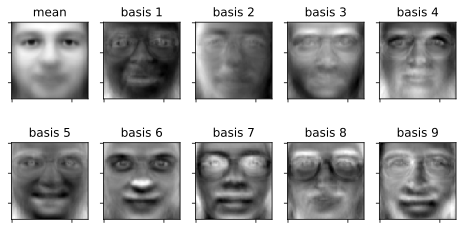

In [100]:
# run the function
plot_basis(pca, imgsize)

_What do the basis images look like? Do some basis images correspond to particular facial features?_
- These basis images are all very similar and all show some of the features of the human face. basis 1 focuses more on the skin color of the face, basis 3 focuses more on the lower cheeks, basis 4 focuses more on the eyes and the left and right cheeks, and the outline of the glasses is clearly visible in basis 1 3 4 4 5 7 8 9.

## Face Recognition
Now train a _linear_ classifier to do the face recognition.  Use the calculated PCA representation as the new set of inputs.  Use cross-validation to set the hyperparameters of the classifier.  _You do not need to do cross-validation for the number of components._  Calculate the average training and testing accuracies.  Remember to transform the test data into the PCA representation too!

**NOTE**: It is **NOT** recommended to use `svm.SVC` for the training.  This is because the default SVC implements 1-vs-1 multi-class classification, which means it will calculate 40x39=1560 classifiers!  All other classifier should be fine since they do 1-vs-all multi-class classification, e.g., LogisticRegressionCV, LinearSVC, etc.  If you want to use svm.SVC, make sure to use the OneVsRestClassifier as shown in Lecture 3.

In [44]:
### INSERT YOUR CODE HERE
import warnings
warnings.filterwarnings('ignore')

In [45]:
# Using Logistic Regression
logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,50),cv=10,n_jobs=-1)
logreg.fit(W_train,trainY)

predYtest = logreg.predict(W_test)
predYtrain = logreg.predict(W_train)

acc_train = metrics.accuracy_score(trainY, predYtrain)
acc_test = metrics.accuracy_score(testY, predYtest)

print("Accuracy on the training set: ", acc_train)
print("Accuracy on the testing set: ", acc_test)
print('C selected: ', logreg.C_)

4510.52s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4510.52s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4510.52s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4510.52s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4510.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4510.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4510.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4510.56s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed.

Accuracy on the training set:  0.965625
Accuracy on the testing set:  0.75
C selected:  [1.75751062 1.75751062 1.75751062 1.75751062 1.75751062 1.75751062
 1.75751062 1.75751062 1.75751062 1.75751062 1.75751062 1.75751062
 1.75751062 1.75751062 1.75751062 1.75751062 1.75751062 1.75751062
 1.75751062 1.75751062 1.75751062 1.75751062 1.75751062 1.75751062
 1.75751062 1.75751062 1.75751062 1.75751062 1.75751062 1.75751062
 1.75751062 1.75751062 1.75751062 1.75751062 1.75751062 1.75751062
 1.75751062 1.75751062 1.75751062 1.75751062]


## Finding the best number of components
Now try a range of number of components for PCA to get the best test accuracy.  Train a classifier for each one and see which dimension gives the best testing accuracy.  Make a plot of PCA dimension vs. test accuracy.

In [46]:
### INSERT YOUR CODE HERE

In [56]:
n_components = arange(1,51)
test_accuracies = empty(50)

for i in range(0,50):
    pca = decomposition.PCA(n_components=n_components[i])
    W_train = pca.fit_transform(trainX)
    W_test = pca.transform(testX)
    # Using Logistic Regression
    logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,50),cv=10,n_jobs=-1)
    logreg.fit(W_train,trainY)

    predYtest = logreg.predict(W_test)

    test_accuracies[i] = metrics.accuracy_score(testY, predYtest)

for i in range(0,50):
    print('n_component:{}, accuracy_score:{}'.format(n_components[i],test_accuracies[i]))

5683.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5683.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5683.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5683.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5683.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5683.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5683.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5683.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed.

n_component:1, accuracy_score:0.1
n_component:2, accuracy_score:0.125
n_component:3, accuracy_score:0.3125
n_component:4, accuracy_score:0.375
n_component:5, accuracy_score:0.5375
n_component:6, accuracy_score:0.65
n_component:7, accuracy_score:0.6875
n_component:8, accuracy_score:0.75
n_component:9, accuracy_score:0.75
n_component:10, accuracy_score:0.825
n_component:11, accuracy_score:0.8625
n_component:12, accuracy_score:0.8875
n_component:13, accuracy_score:0.9
n_component:14, accuracy_score:0.9
n_component:15, accuracy_score:0.9
n_component:16, accuracy_score:0.9
n_component:17, accuracy_score:0.925
n_component:18, accuracy_score:0.9375
n_component:19, accuracy_score:0.925
n_component:20, accuracy_score:0.925
n_component:21, accuracy_score:0.925
n_component:22, accuracy_score:0.925
n_component:23, accuracy_score:0.9375
n_component:24, accuracy_score:0.925
n_component:25, accuracy_score:0.9375
n_component:26, accuracy_score:0.95
n_component:27, accuracy_score:0.925
n_component:28, 

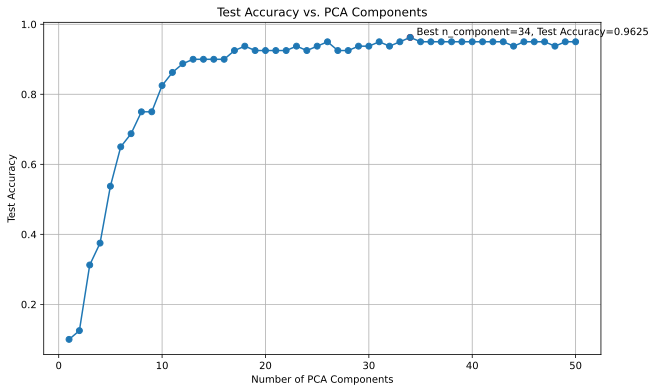

best n_components:  34
best accuracy:  0.9625


In [57]:
# Plotting the accuracies
plt.figure(figsize=(10,6))
plt.plot(n_components, test_accuracies, marker='o')
plt.title('Test Accuracy vs. PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Test Accuracy')
plt.grid(True)

# Highlighting the best n_component with the highest test_accuracy
best_index = argmax(test_accuracies)
plt.scatter(n_components[best_index], test_accuracies[best_index], color='r')
plt.text(n_components[best_index], test_accuracies[best_index], f'  Best n_component={n_components[best_index]}, Test Accuracy={test_accuracies[best_index]}', verticalalignment='bottom')

plt.show()

print('best n_components: ', n_components[best_index])
print('best accuracy: ', test_accuracies[best_index])

_What is the best number of components?  View the basis images to see what they look like_

The best number of components is 34, with the highest accuracy of 0.9625.
Since the basis images we already made contains only 9 basis images, we can draw the new set of basis images when n_components = 50 below to see the all 50 basis images: 

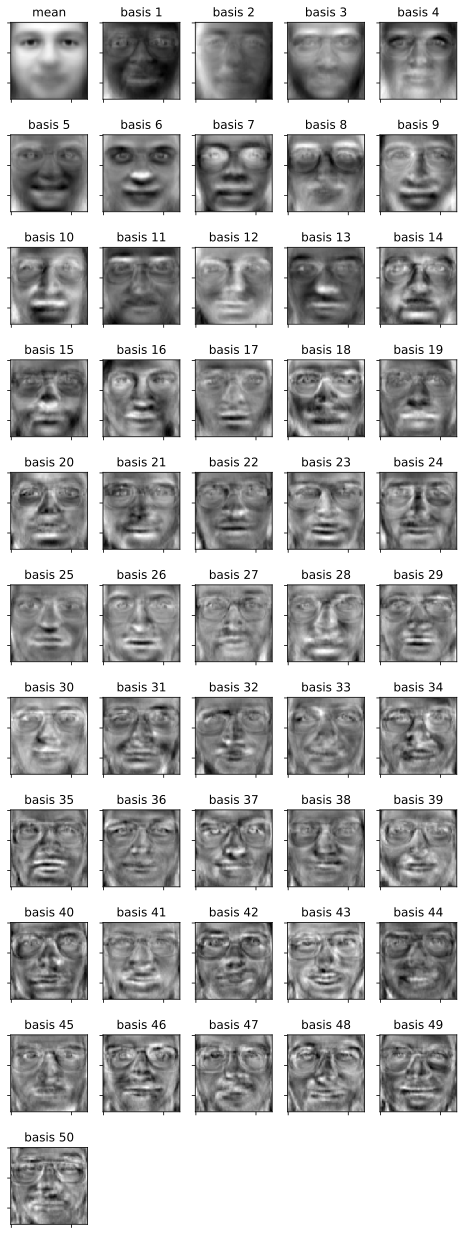

In [58]:
plot_basis(pca, imgsize)

We can see that accuracy converges after about 15 components, which corresponds to the basis image, and it is easy to see that the images before basis 15 are focused on a particularly specific part of the face, and everything else is blurry, but after 15 the individual features of the face are uniformly clear. The accuracy score is at maximal when n_components is at 35, which probably because of the small fluctuations after convergence, it is not significantly different from the surrounding basis images.

# Linear Dimensionality Reduction - NMF
Now we will repeat the experiment using non-negative matrix factorization instead of PCA.  Perform NMF with 9 components and visualize the basis images.

In [59]:
nmf = decomposition.NMF(n_components=9)
W_nmf_train = nmf.fit_transform(trainX)
W_nmf_test = nmf.transform(testX)  # returns the coefficients

print(W_nmf_train.shape)
print(W_nmf_test.shape)

(320, 9)
(80, 9)


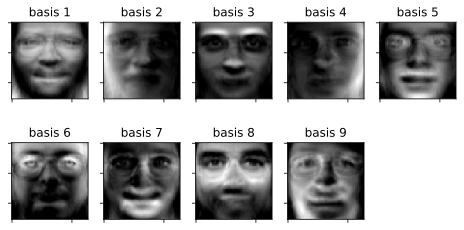

In [60]:
### INSERT YOUR CODE HERE

plot_basis(nmf,imgsize)

_What do the basis images look like?  What is the main difference with the PCA basis images?_
- These basis images are some very shadowy faces. Compared with PCA, NMF outputs darker basis images, with some of the features of the face more clearly defined (but due to the darkness, at first glance it doesn't look like a human face, but more like a ghost), and have deeper values for some facial features.

## Finding the best number of components
Now find the number of components that gives the best test accuracy.  Use the same type of classifier that you used in the previous experiment.  Use cross-validation to select the hyperparameters of the classifier.  You do not need to do cross-validation for the number of components.

In [62]:
n_components = arange(1,51)
test_accuracies = empty(50)

for i in range(0,50):
    nmf = decomposition.NMF(n_components=n_components[i])
    W_train = nmf.fit_transform(trainX)
    W_test = nmf.transform(testX)
    # Using Logistic Regression
    logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,50),cv=10,n_jobs=-1)
    logreg.fit(W_train,trainY)

    predYtest = logreg.predict(W_test)

    test_accuracies[i] = metrics.accuracy_score(testY, predYtest)

for i in range(0,50):
    print('n_component:{}, accuracy_score:{}'.format(n_components[i],test_accuracies[i]))

/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

n_component:1, accuracy_score:0.1125
n_component:2, accuracy_score:0.1375
n_component:3, accuracy_score:0.25
n_component:4, accuracy_score:0.5
n_component:5, accuracy_score:0.575
n_component:6, accuracy_score:0.6375
n_component:7, accuracy_score:0.6875
n_component:8, accuracy_score:0.7375
n_component:9, accuracy_score:0.7375
n_component:10, accuracy_score:0.7375
n_component:11, accuracy_score:0.8125
n_component:12, accuracy_score:0.775
n_component:13, accuracy_score:0.825
n_component:14, accuracy_score:0.8125
n_component:15, accuracy_score:0.8375
n_component:16, accuracy_score:0.8
n_component:17, accuracy_score:0.8
n_component:18, accuracy_score:0.8125
n_component:19, accuracy_score:0.825
n_component:20, accuracy_score:0.7375
n_component:21, accuracy_score:0.8
n_component:22, accuracy_score:0.8125
n_component:23, accuracy_score:0.8
n_component:24, accuracy_score:0.825
n_component:25, accuracy_score:0.8125
n_component:26, accuracy_score:0.8375
n_component:27, accuracy_score:0.775
n_comp

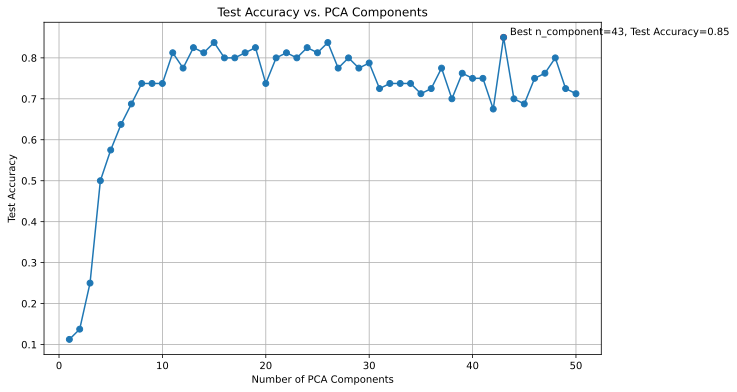

best n_components:  43
best accuracy:  0.85


In [63]:
# Plotting the accuracies
plt.figure(figsize=(10,6))
plt.plot(n_components, test_accuracies, marker='o')
plt.title('Test Accuracy vs. PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Test Accuracy')
plt.grid(True)

# Highlighting the best n_component with the highest test_accuracy
best_index = argmax(test_accuracies)
plt.scatter(n_components[best_index], test_accuracies[best_index], color='r')
plt.text(n_components[best_index], test_accuracies[best_index], f'  Best n_component={n_components[best_index]}, Test Accuracy={test_accuracies[best_index]}', verticalalignment='bottom')

plt.show()

print('best n_components: ', n_components[best_index])
print('best accuracy: ', test_accuracies[best_index])

_Which number of components give the best test result? How does the accuracy compare to the best PCA result?  Why is NMF or PCA better?_
- The highest accuracy value is found at component=43, but based on the images it can be seen that the trend of accuracy reaches extremely high values at component=15 and then slowly decreases, components=43 may be due to mutation.
- The reason might be that the structure in your data is due to correlations between features rather than being parts-based, and NMF works well when the data is constructed from several parts or sources.

In [ ]:
### INSERT YOUR CODE HERE

# Non-Linear Dimensionality Reduction - KPCA
Now we will use KPCA to perform non-linear dimensionality reduction on the data  before training the classifier.  Run KPCA on the data using 10 principal components.  Use the RBF kernel with gamma=0.001.

In [64]:
### INSERT YOUR CODE HERE ###
kpca = decomposition.KernelPCA(n_components=10, kernel='rbf',gamma=0.001)

W_kpca_train = kpca.fit_transform(trainX)
W_kpca_test = kpca.transform(testX)

The below function will plot the basis vectors of KPCA. Run the next 2 cells to view the PCs.  The kernel PCs are a combination of similarities to points in the training set.  The PCs are visualized by showing the top 5 positive and negative training examples, along with their coefficient $\alpha_i$.

In [65]:
def plot_kbasis(model, imgsize, X):
    KK = model.n_components
    alphas = model.eigenvectors_.T
    minmax = 5
    
    py = KK
    px = minmax*2
    for i in range(KK):
        # sort alphas
        inds = argsort(alphas[i,:])

        myi = r_[arange(-1,-minmax-1,-1), arange(minmax-1,-1,-1)]
        myinds = inds[myi]
        
        for j,jj in enumerate(myinds):
            plt.subplot(py,px,(j+1)+i*px)
            plt.imshow(X[jj,:].reshape(imgsize), interpolation='nearest')
            plt.gray()
            if alphas[i,jj]<0:
                mycol = 'b'
            else:
                mycol = 'r'
            plt.title("{:.3f}".format(alphas[i,jj]), fontsize=7, color=mycol)
            if (j==0):
                plt.ylabel('PC' + str(i+1))
            plt.xticks([])
            plt.yticks([])

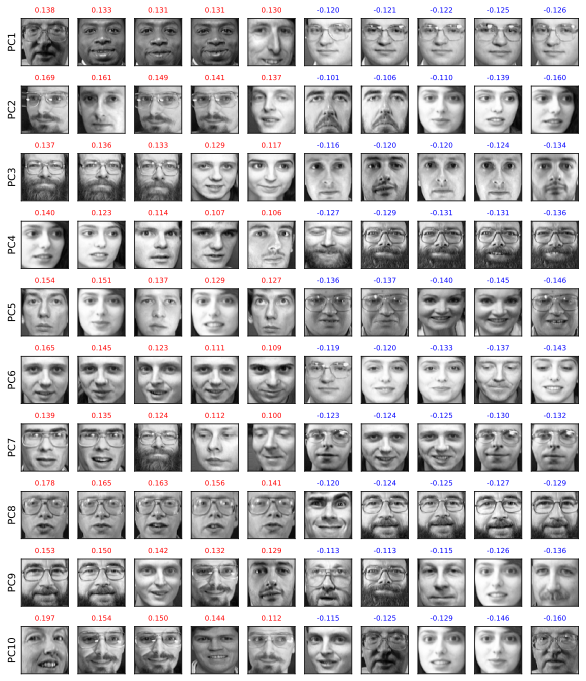

In [66]:
# run the function
plt.figure(figsize=(10,12))
plot_kbasis(kpca, imgsize, trainX)

_What is the interpretation for the KPCA basis?  What kind of faces do some of the PCs prefer?_
- The  KPCA extends PCA to handle non-linear data by using a kernel function to map the data to a higher-dimensional space where it is linearly separable.
- Different PCs perfer different part of face:
- PC1: skin colors;
- PC2: directions faces towards;
- PC3: beard;
- PC4: beard;
- PC5: nose shape;
- PC6: depth of the eye socket;
- PC7: glasses, beard, face towarding, ...(it is hard to tell)
- PC8: glasses;
- PC9: glasses, gender, ...(it is hard to tell)
- PC10: glasses, gender, ...(it is hard to tell)

## Finding the best kernel and best number of components
Now try different kernels (poly, RBF, etc), kernel parameters, and number of components to get the best test accuracy.  Train a classifier for each one and see which dimension gives the best testing accuracy.  Make a plots of number of components vs. test accuracy.

In [73]:
# Try 'poly' kernel with different degrees
n_components = arange(1,51)
degrees = [2, 3, 4, 5, 6]
test_accuracies = empty((len(degrees), 50))
for j, degree in enumerate(degrees):
    for i in range(50):
        kpca = decomposition.KernelPCA(n_components=n_components[i], kernel='poly', degree=degree)
        W_train = kpca.fit_transform(trainX)
        W_test = kpca.transform(testX)

        logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4, 4, 50), cv=10, n_jobs=-1)
        logreg.fit(W_train, trainY)

        predYtest = logreg.predict(W_test)

        test_accuracies[j, i] = metrics.accuracy_score(testY, predYtest)

/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

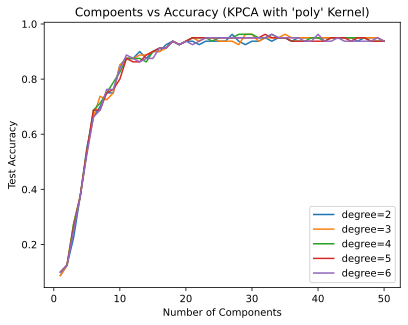

In [80]:
for i in range(len(degrees)):
    plt.plot(n_components, test_accuracies[i], label=f'degree={degrees[i]}')

plt.title('Compoents vs Accuracy (KPCA with \'poly\' Kernel)')
plt.xlabel('Number of Components')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

In [91]:
import numpy as np

max_index = argmax(test_accuracies)
best_degree = degrees[max_index // 50]
best_n_components = n_components[max_index % 50]

print(f"best accuracy: {np.max(test_accuracies)} with degree: {best_degree} and n_components: {best_n_components}.")

26
best accuracy: 0.9625 with degree: 2 and n_components: 27.


In [83]:
n_components = arange(1, 51)
kernel = 'rbf'
gammas = [0.001, 0.01, 0.1, 0.2, 0.5, 1]  # Gamma values for rbf kernel
test_accuracies = empty((len(gammas), 50))

for j, gamma in enumerate(gammas):
    for i in range(50):
        kpca = decomposition.KernelPCA(n_components=n_components[i], kernel=kernel, gamma=gamma)
        W_train = kpca.fit_transform(trainX)
        W_test = kpca.transform(testX)

        logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4, 4, 50), cv=10, n_jobs=-1)
        logreg.fit(W_train, trainY)

        predYtest = logreg.predict(W_test)

        test_accuracies[j, i] = metrics.accuracy_score(testY, predYtest)


/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

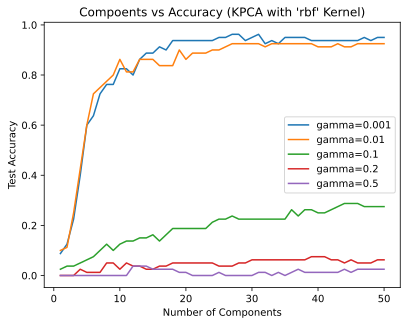

In [84]:
for i in range(len(degrees)):
    plt.plot(n_components, test_accuracies[i], label=f'gamma={gammas[i]}')

plt.title('Compoents vs Accuracy (KPCA with \'rbf\' Kernel)')
plt.xlabel('Number of Components')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

In [97]:
max_index = argmax(test_accuracies)

best_gamma = gammas[max_index // len(n_components)]
best_n_components = n_components[max_index % len(n_components)]

print(f"best accuracy: {np.max(test_accuracies)} with gamma: {best_gamma} and n_components: {best_n_components}.")

best accuracy: 0.9625 with gamma: 0.001 and n_components: 27.


_What is the best kernel and number of components?_
- The results using the rbf kernel and using the poly kernel are both roughly the same, they both possess an accuracy of 0.9825 (the best n_components is 27 in both KPCA).

*Which dimensionality reduction method performs the best for classification? Why?*
- The results of PCA and KPCA were better than NMF, while the accuracies of both PCA and KPCA were 0.925. I think the data data might be linearly separable, and KPCA may do not provide additional benefits for this dataset.

# De-noising with dimensionality reduction

In this section, we will  use dimensionality reduction for denoising a face image. Given a noisy image $\mathbf{x}$, we first compute the low-dimensional representation $\mathbf{w}$, e.g., using PCA. Then given $\mathbf{w}$, we reconstruct the image $\hat{\mathbf{x}}$ from the PCA/NMF basis.  In sklearn, the reconstruction step can be achieved using the `inverse_transform()` method of the PCA or NMF classes.

Train a PCA or NMF model using a large number of components (e.g., 100) on the face dataset, and then test it for denoising. For the noisy images, you can try different types of noise, such as:
- additive noise (using `random.normal`)
- salt & pepper noise (using `random.binomial`)
- masking out part of the image (the masked out part can be replaced with black, gray, or white).


for evaluation of the reconstruction or denoising result you can use "peak signal to noise ratio", which is implemented in skimage as `skimage.metrics.peak_signal_noise_ratio` or `skimage.measure.compare_psnr` (on older versions).

In [6]:
import skimage

In [35]:
# Additive noise
noisyX_normal = trainX + random.normal(size=trainX.shape)
noisyXt_normal = testX + random.normal(size=testX.shape)

pca = decomposition.PCA(n_components=200)
W_train = pca.fit_transform(noisyX_normal)
W_test = pca.transform(noisyXt_normal)  # returns the coefficients
reconstructed_normal = pca.inverse_transform(W_test)

psnr_normal = skimage.metrics.peak_signal_noise_ratio(testX, reconstructed_normal)

print(f'PSNR for additive noise: {psnr_normal}')

PSNR for additive noise: 11.817801994777113


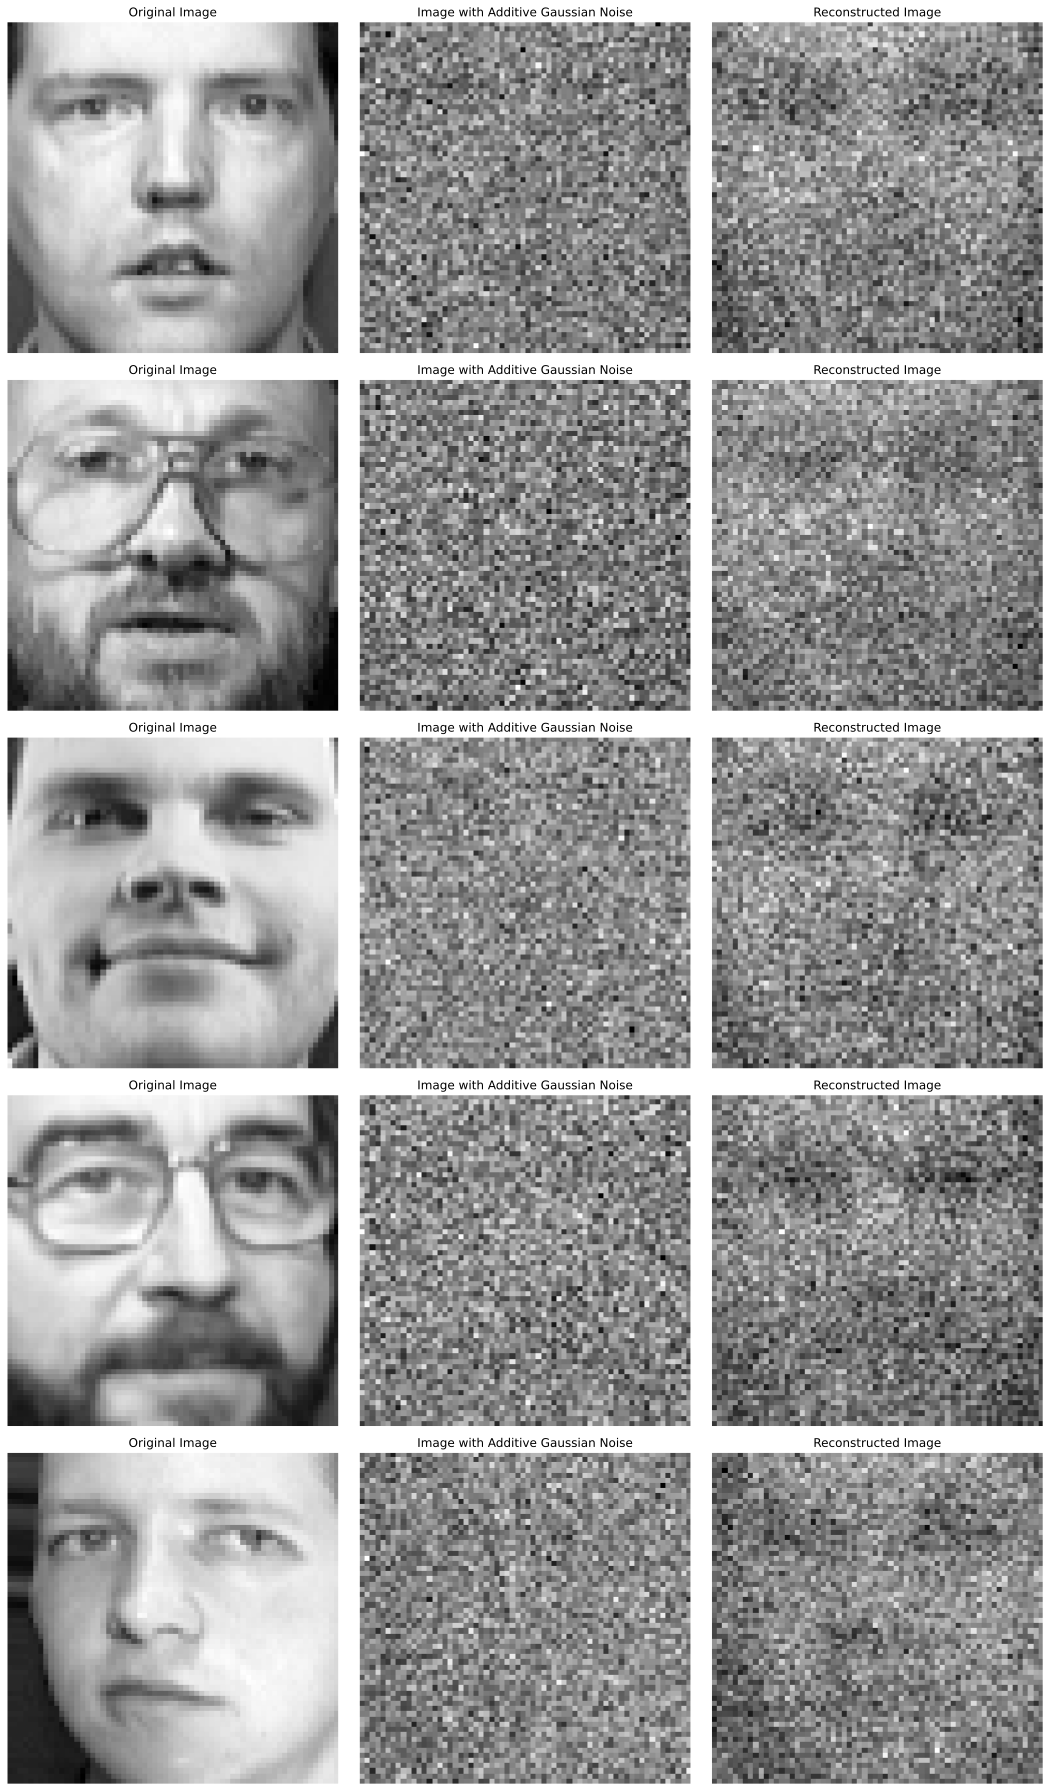

In [36]:
fig, ax = plt.subplots(5, 3, figsize=(15, 25))
for i in range(5):
    original_image = testX[i]
    noisy_image = noisyXt_normal[i]
    reconstructed_image = reconstructed_normal[i]
    # Plotting original, noisy, and reconstructed images
    ax[i, 0].imshow(original_image.reshape(imgsize), cmap='gray')
    ax[i, 0].set_title('Original Image')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(noisy_image.reshape(imgsize), cmap='gray')
    ax[i, 1].set_title('Image with Additive Gaussian Noise')
    ax[i, 1].axis('off')

    ax[i, 2].imshow(reconstructed_image.reshape(imgsize), cmap='gray')
    ax[i, 2].set_title('Reconstructed Image')
    ax[i, 2].axis('off')
plt.tight_layout()
plt.show()

In [57]:
# Binomial Noise
noisyX_binomial = trainX + random.binomial(1, 0.1, size=trainX.shape)
noisyXt_binomial = testX + random.binomial(1, 0.1, size=testX.shape)

pca = decomposition.PCA(n_components=200)
W_train = pca.fit_transform(noisyX_binomial)
W_test = pca.transform(noisyXt_binomial) 
reconstructed_binomial = pca.inverse_transform(W_test)

psnr_normal = skimage.metrics.peak_signal_noise_ratio(testX, reconstructed_binomial)

print(f'PSNR for Binomial noise: {psnr_normal}')

PSNR for Binomial noise: 16.540642035462565


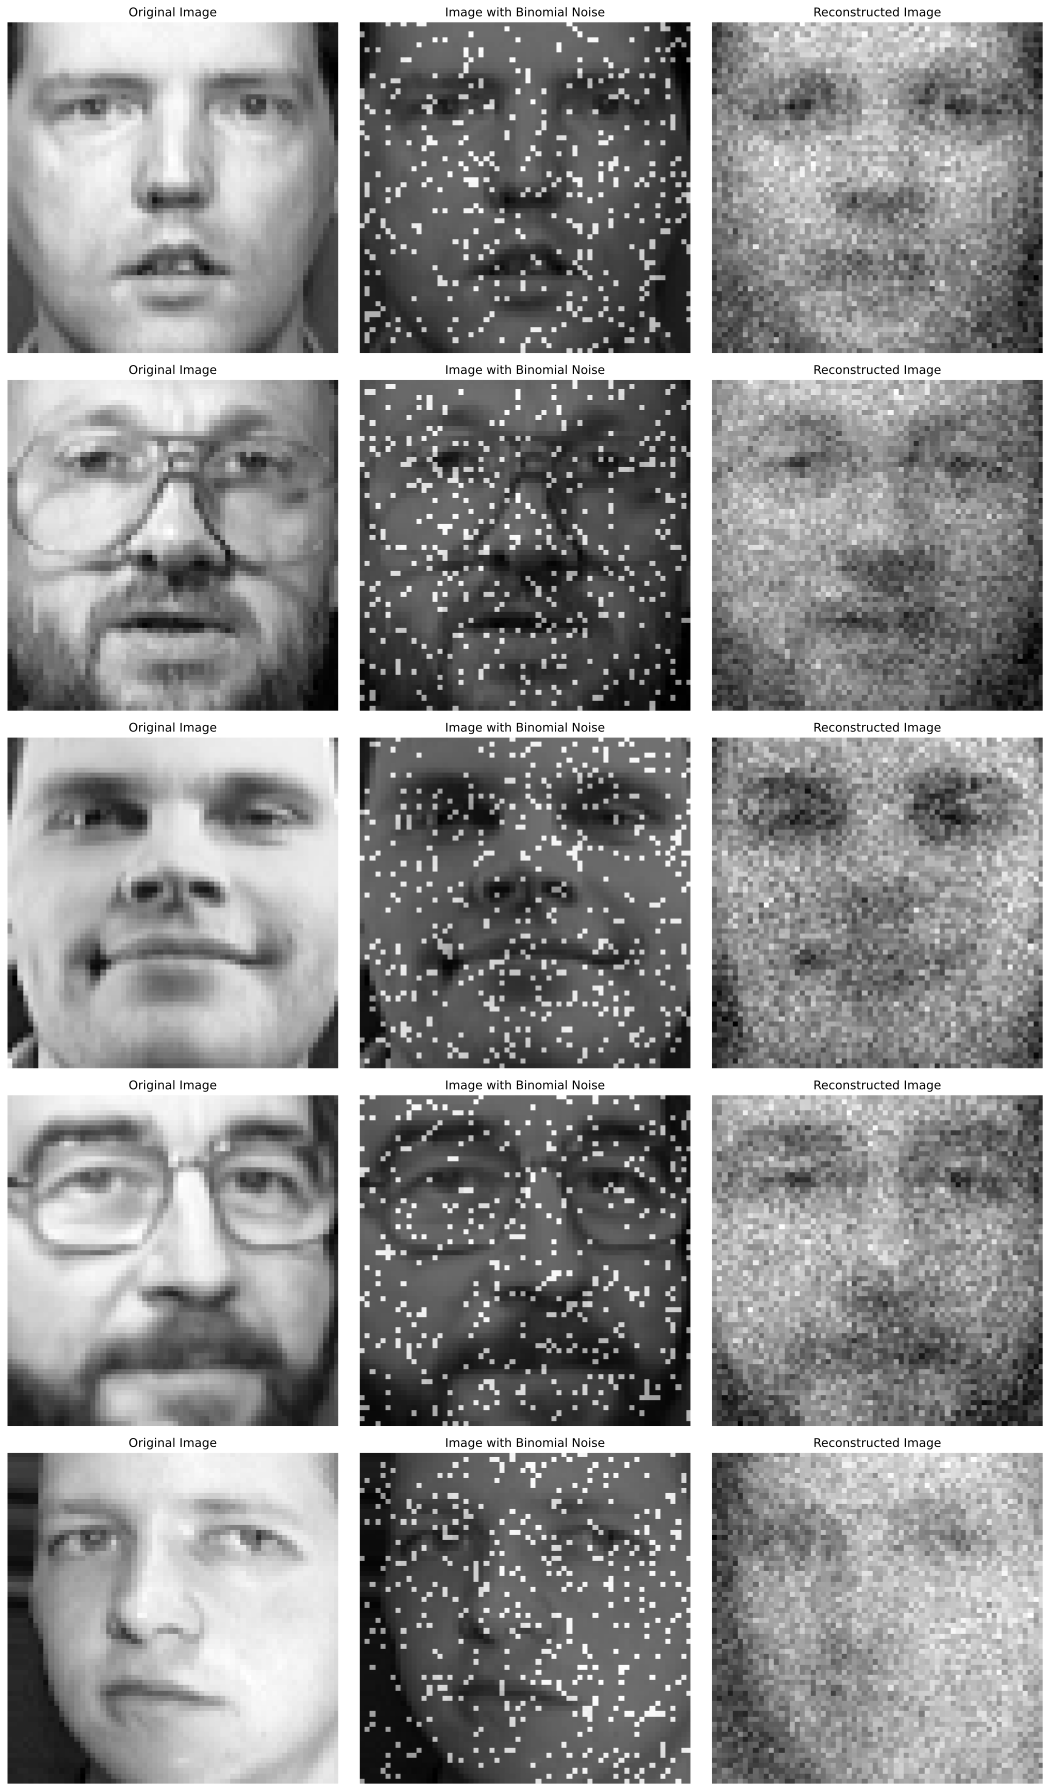

In [58]:
fig, ax = plt.subplots(5, 3, figsize=(15, 25))
for i in range(5):
    original_image = testX[i]
    noisy_image = noisyXt_binomial[i]
    reconstructed_image = reconstructed_binomial[i]
    # Plotting original, noisy, and reconstructed images
    ax[i, 0].imshow(original_image.reshape(imgsize), cmap='gray')
    ax[i, 0].set_title('Original Image')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(noisy_image.reshape(imgsize), cmap='gray')
    ax[i, 1].set_title('Image with Binomial Noise')
    ax[i, 1].axis('off')

    ax[i, 2].imshow(reconstructed_image.reshape(imgsize), cmap='gray')
    ax[i, 2].set_title('Reconstructed Image')
    ax[i, 2].axis('off')
plt.tight_layout()
plt.show()

In [74]:
# Masking noise
mask = random.choice([0,1], size=trainX.shape, p=[0.5,0.5])
noisyX_masked = where(mask == 1, trainX, 0)  # black mask
mask_t = random.choice([0,1], size=testX.shape, p=[0.5,0.5])
noisyXt_masked = where(mask_t == 1, testX, 0)  # black mask

pca = decomposition.PCA(n_components=200)
W_train = pca.fit_transform(noisyX_masked)
W_test = pca.transform(noisyXt_masked) 
reconstructed_masked = pca.inverse_transform(W_test)

psnr_normal = skimage.metrics.peak_signal_noise_ratio(testX, reconstructed_masked)

print(f'PSNR for Masked noise: {psnr_normal}')

PSNR for Masked noise: 10.19563878584728


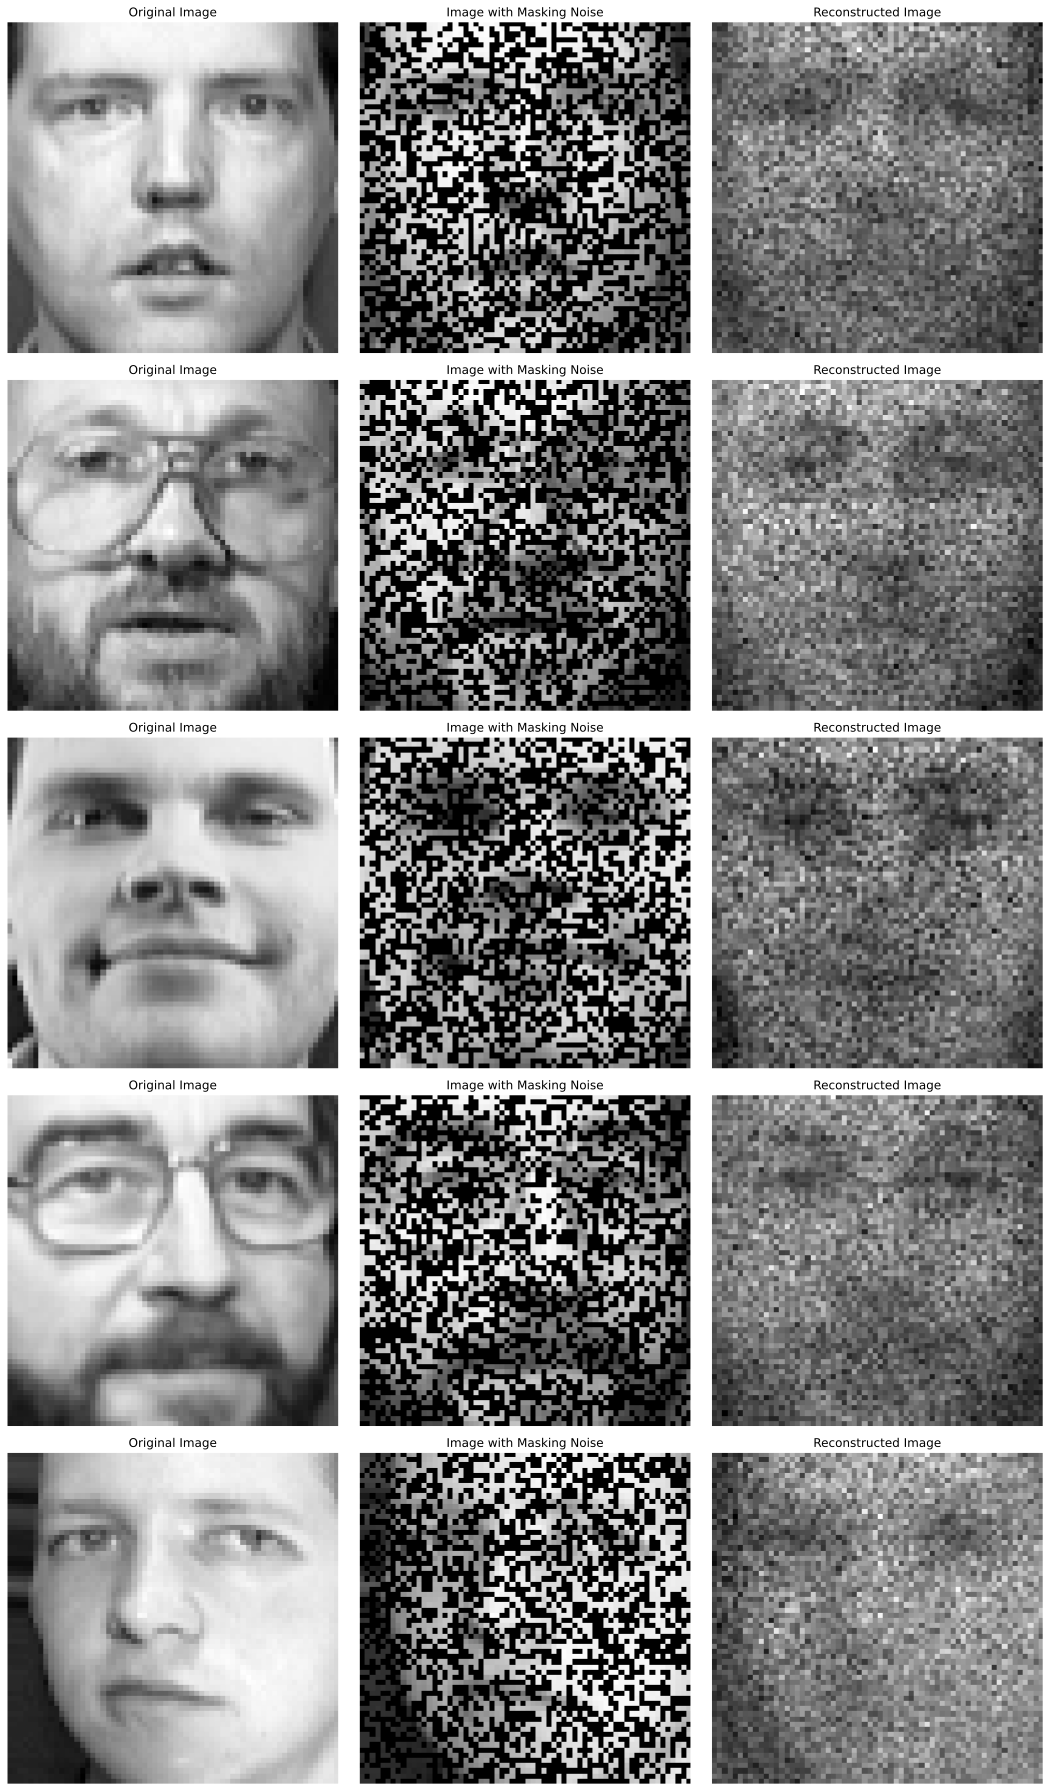

In [75]:
fig, ax = plt.subplots(5, 3, figsize=(15, 25))
for i in range(5):
    original_image = testX[i]
    noisy_image = noisyXt_masked[i]
    reconstructed_image = reconstructed_masked[i]
    # Plotting original, noisy, and reconstructed images
    ax[i, 0].imshow(original_image.reshape(imgsize), cmap='gray')
    ax[i, 0].set_title('Original Image')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(noisy_image.reshape(imgsize), cmap='gray')
    ax[i, 1].set_title('Image with Masking Noise')
    ax[i, 1].axis('off')

    ax[i, 2].imshow(reconstructed_image.reshape(imgsize), cmap='gray')
    ax[i, 2].set_title('Reconstructed Image')
    ax[i, 2].axis('off')
plt.tight_layout()
plt.show()

In [60]:
noisyX_sp = skimage.util.random_noise(trainX, mode='s&p')
noisyXt_sp = skimage.util.random_noise(testX, mode='s&p')

pca = decomposition.PCA(n_components=200)
W_train = pca.fit_transform(noisyX_sp)
W_test = pca.transform(noisyXt_sp) 
reconstructed_sp = pca.inverse_transform(W_test)

psnr_sp = skimage.metrics.peak_signal_noise_ratio(testX, reconstructed_sp)

print(f'PSNR for Salt & Pepper noise: {psnr_sp}')

PSNR for Salt & Pepper noise: 22.74048330962833


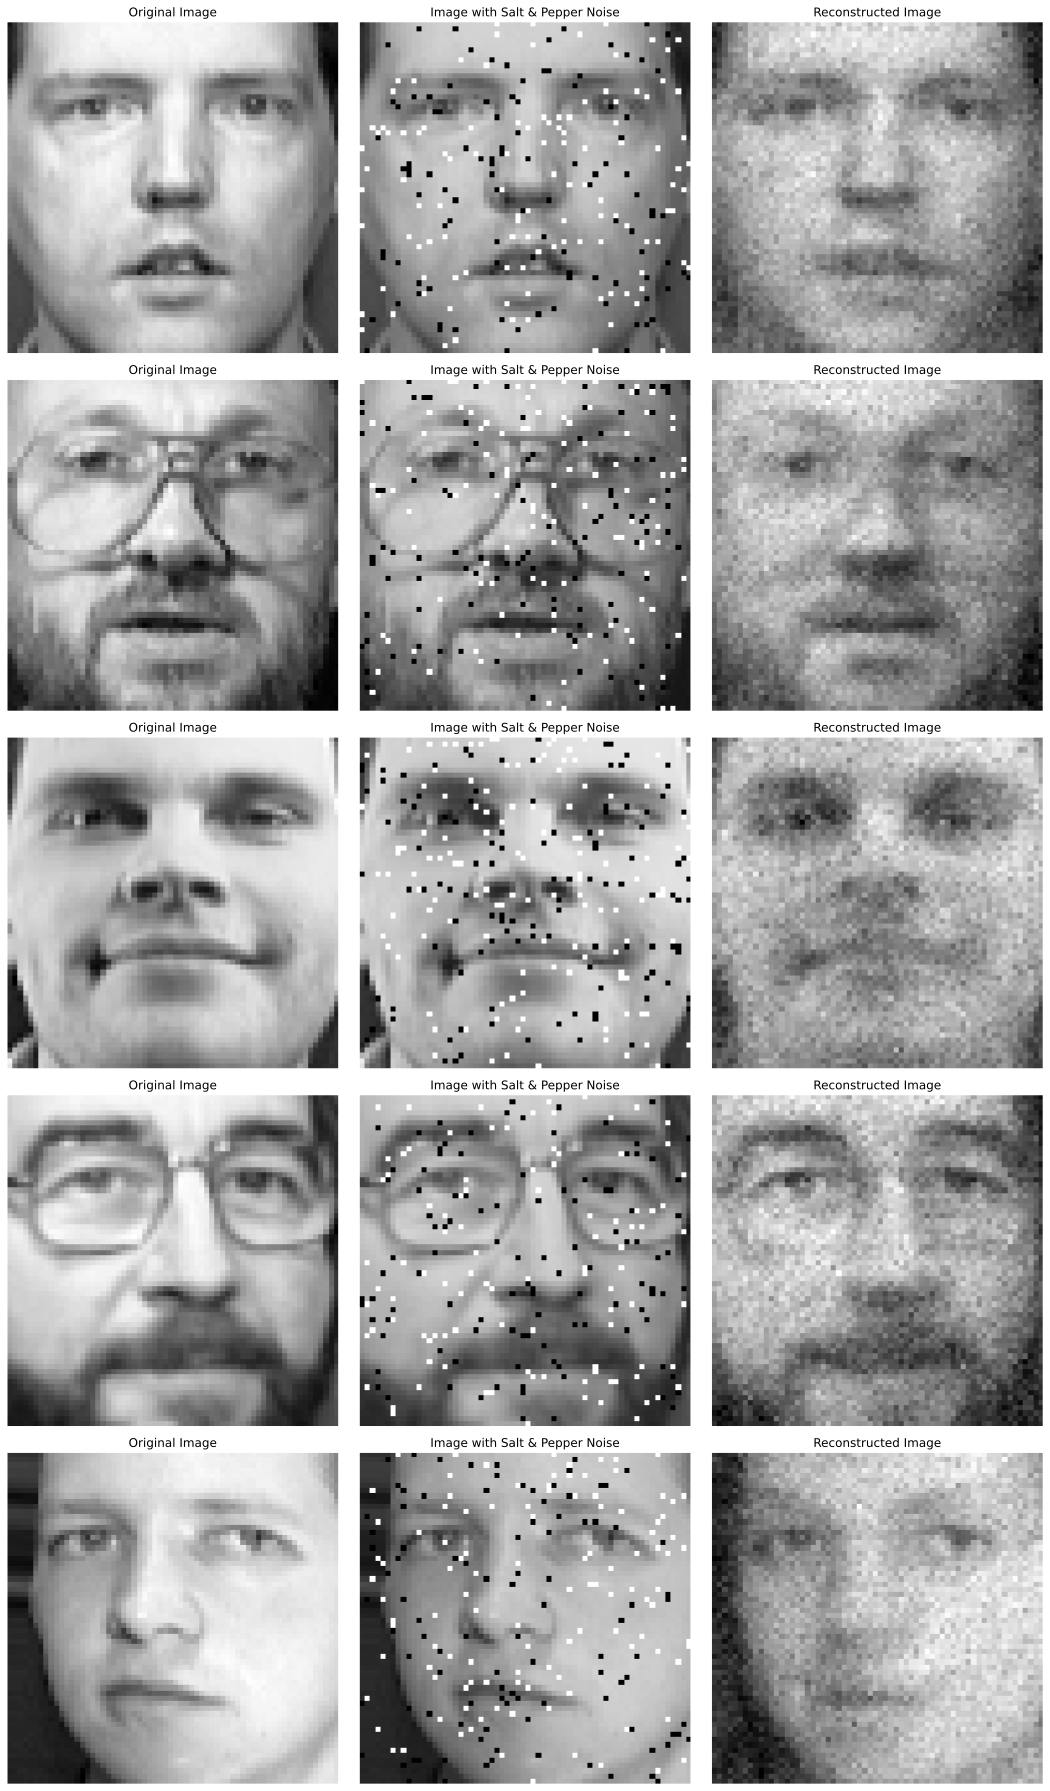

In [76]:
fig, ax = plt.subplots(5, 3, figsize=(15, 25))
for i in range(5):
    original_image = testX[i]
    noisy_image = noisyXt_sp[i]
    reconstructed_image = reconstructed_sp[i]
    # Plotting original, noisy, and reconstructed images
    ax[i, 0].imshow(original_image.reshape(imgsize), cmap='gray')
    ax[i, 0].set_title('Original Image')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(noisy_image.reshape(imgsize), cmap='gray')
    ax[i, 1].set_title('Image with Salt & Pepper Noise')
    ax[i, 1].axis('off')

    ax[i, 2].imshow(reconstructed_image.reshape(imgsize), cmap='gray')
    ax[i, 2].set_title('Reconstructed Image')
    ax[i, 2].axis('off')
plt.tight_layout()
plt.show()

_Which kind of noise can be handled well by linear dimensionality reduction? Why?_
- Based on the PSNR values, linear dimensionality reduction is better able to handle Salt & Pepper Noise. We can see from the figures that Salt & Pepper Noise can less affect the figure, and therefore PCA can better capture the main variance directions. Furthermore, the masking noise are not handled well by linear dimensionality reduction, and I guess the PSNR values might be negatively correlated to the area of the mask.